In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, balanced_accuracy_score
import numpy as np
import pickle



from utils.general_utils import get_outlier_info, get_outlier_val_counts

In [2]:
og_df = pd.read_csv('dataset/TrainDataset2023.csv')
og_df.rename(columns={'pCR (outcome)': 'pcr', 'RelapseFreeSurvival (outcome)': 'rfs'}, inplace=True)

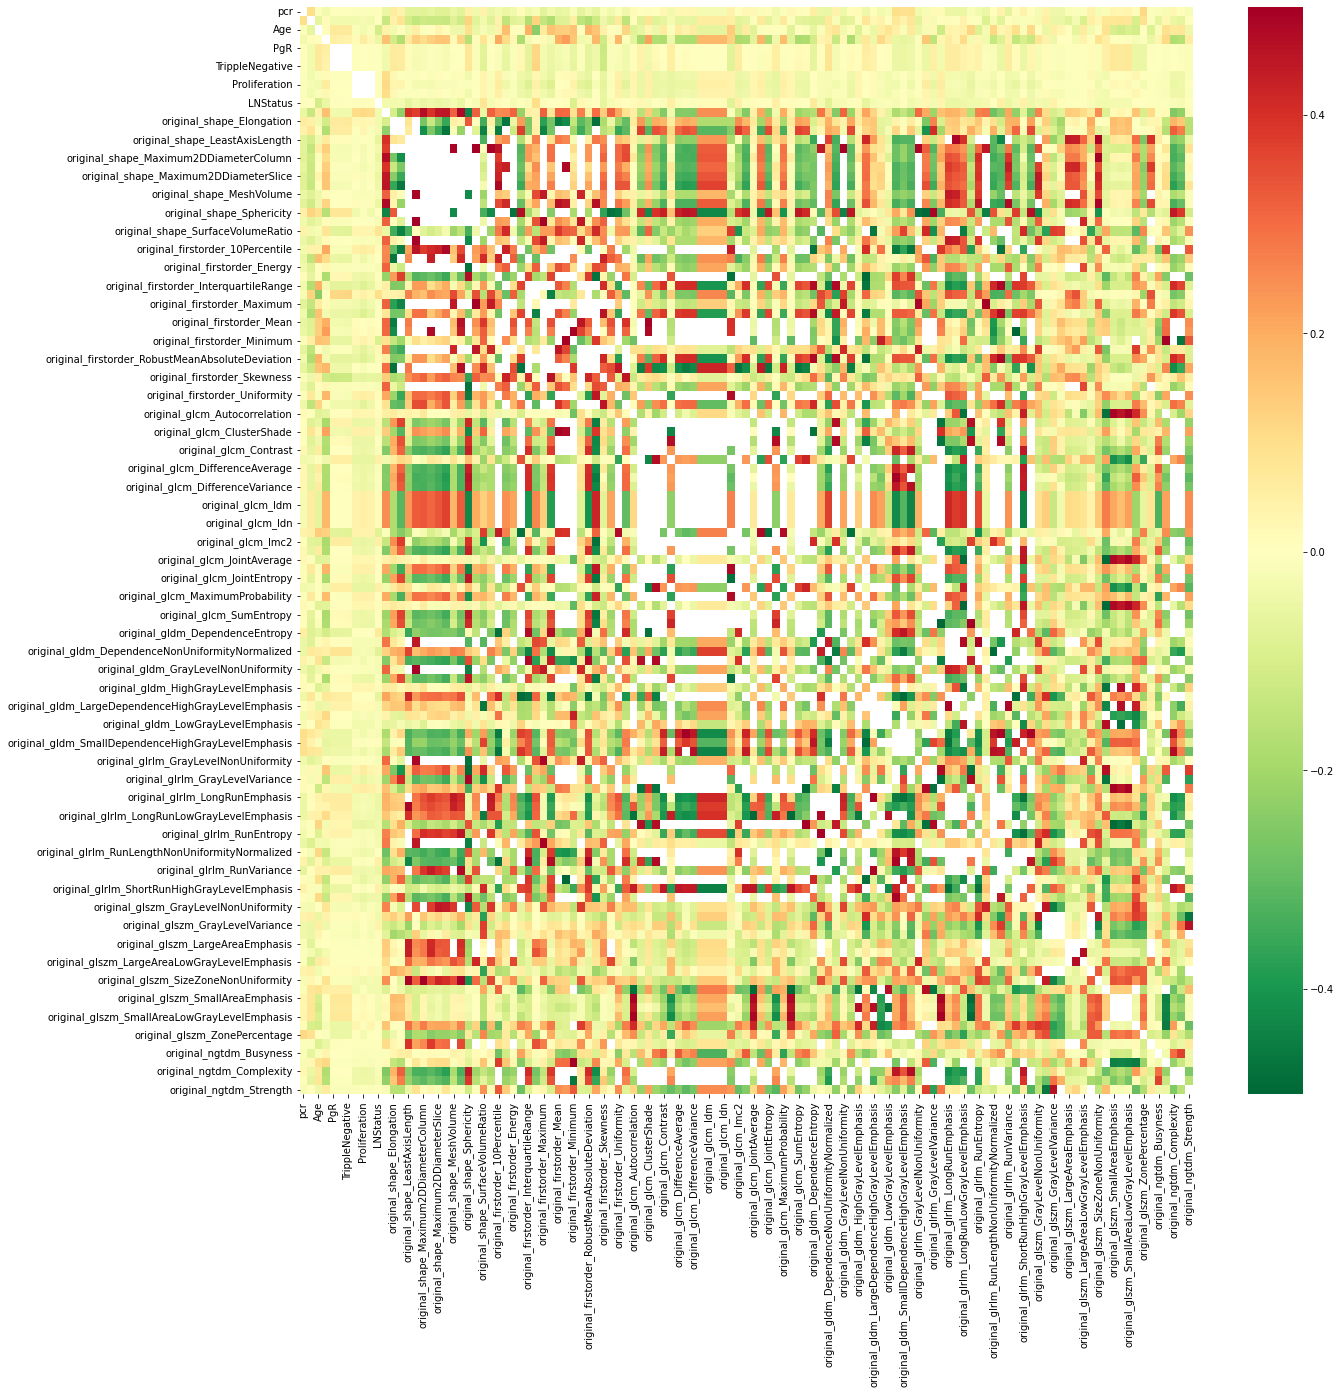

In [3]:
corr = og_df.drop(columns=['ID']).corr() 
corr_abs = corr.abs()
plt.figure(figsize=(20,20)) 
sns.heatmap(corr, cmap='RdYlGn_r', mask = (corr_abs >= 0.5)) 
plt.show()

In [4]:
# Taking values above the diagonal getting the values only from it and making the other elements to NaN.
upper = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))

#Then taking values (absolute) of the each element and choosing the column to drop by various correlation threshold vales
to_drop_95 = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop_90 = [column for column in upper.columns if any(upper[column] > 0.90)]
to_drop_85 = [column for column in upper.columns if any(upper[column] > 0.85)]
to_drop_80 = [column for column in upper.columns if any(upper[column] > 0.80)]

print(f'Thresholding 95% correlated drop columns : {len(to_drop_95)}')
print(f'Thresholding 90% correlated drop columns : {len(to_drop_90)}')
print(f'Thresholding 85% correlated drop columns : {len(to_drop_85)}')
print(f'Thresholding 80% correlated drop columns : {len(to_drop_80)}')

Thresholding 95% correlated drop columns : 49
Thresholding 90% correlated drop columns : 64
Thresholding 85% correlated drop columns : 76
Thresholding 80% correlated drop columns : 85


# Dropping features with correlation more than 90%

In [8]:
# with open(f'dataset/dataset_v1/columns_dropped.txt', 'w') as f:
#     f.write(str(to_drop_90))


In [9]:
# Drop features 
fs_df_v1 = og_df.drop(to_drop_90, axis=1)

In [10]:
fs_df_v1.head()

,ID,pcr,rfs,Age,ER,PgR,ChemoGrade,Proliferation,LNStatus,TumourStage,...,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_ngtdm_Busyness,original_ngtdm_Strength
0,TRG002174,1,144.0,41.0,0,0,3,3,1,2,...,1.272727,4067578.818,1.565522e+07,1.170667e+06,0.180900,0.403535,3.325332,0.002314,473.464852,0.000758
1,TRG002178,0,142.0,39.0,1,1,3,3,1,2,...,1.037500,2403756.075,9.614769e+06,6.010027e+05,0.198125,0.444391,3.032144,0.005612,59.459710,0.003685
2,TRG002204,1,135.0,31.0,0,0,2,1,0,2,...,1.040541,1561963.432,6.247801e+06,3.905040e+05,0.275749,0.534549,2.485848,0.006752,33.935384,0.006447
3,TRG002206,0,12.0,35.0,0,0,3,3,1,3,...,1.029703,7007670.723,2.803063e+07,1.751932e+06,0.253014,0.506185,2.606255,0.003755,46.859265,0.004543
4,TRG002210,0,109.0,61.0,1,0,2,1,0,2,...,1.051724,1288913.690,5.155465e+06,3.222760e+05,0.216409,0.462282,2.809279,0.006521,39.621023,0.005626


# Handling Missing values using KNN

In [11]:
missing_vals = np.sum(fs_df_v1 == 999)
missing_cols_valuecounts = missing_vals[missing_vals > 0]
missing_cols_valuecounts

pcr              5
PgR              1
ChemoGrade       3
Proliferation    2
LNStatus         1
dtype: int64

In [12]:
missing_vals[missing_vals > 0].keys()

Index(['pcr', 'PgR', 'ChemoGrade', 'Proliferation', 'LNStatus'], dtype='object')

In [13]:
fs_df_v1[fs_df_v1['pcr'] == 999]

,ID,pcr,rfs,Age,ER,PgR,ChemoGrade,Proliferation,LNStatus,TumourStage,...,original_glszm_HighGrayLevelZoneEmphasis,original_glszm_LargeAreaEmphasis,original_glszm_LargeAreaHighGrayLevelEmphasis,original_glszm_LargeAreaLowGrayLevelEmphasis,original_glszm_SizeZoneNonUniformityNormalized,original_glszm_SmallAreaEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_ngtdm_Busyness,original_ngtdm_Strength
10,TRG002244,999,129.000000,49.0,1,1,2,1,1,2,...,1.036145,1.827734e+06,7309392.566,457319.14760,0.164755,0.401346,3.463495,0.006314,130.130448,0.001858
342,TRG002859,999,77.250000,50.8,0,0,2,1,0,2,...,1.073171,2.201233e+06,8804891.829,550318.65850,0.298037,0.552088,2.358335,0.004267,17.550245,0.012191
366,TRG002895,999,65.583333,49.0,0,0,3,3,0,1,...,1.125000,2.734502e+05,1081806.333,71361.17708,0.315972,0.559912,2.497224,0.008024,67.742319,0.004422
372,TRG002904,999,63.666667,54.9,0,0,3,1,0,2,...,1.250000,8.222810e+05,3273071.250,209583.43750,0.125000,0.286114,3.188722,0.003482,40.350115,0.006673
373,TRG002905,999,63.666667,51.8,1,1,3,2,1,4,...,1.157895,3.654555e+05,1461754.211,91380.85526,0.218837,0.407157,2.615320,0.007045,10.460087,0.021602


In [14]:
from sklearn.impute import KNNImputer

In [15]:
impute_knn = KNNImputer(n_neighbors=3, missing_values=999)
imputed_arr = impute_knn.fit_transform(fs_df_v1.drop(columns=['ID']))

### All the missing values are from the classification target column and other categorical features, So we round the KNN imputed values to the nearest neighbour

In [16]:
print(f'Columns which has missing values : {list(missing_cols_valuecounts.keys())}')

Columns which has missing values : ['pcr', 'PgR', 'ChemoGrade', 'Proliferation', 'LNStatus']


In [17]:
imputed_arr[:,0] = np.rint(imputed_arr[:,0])
imputed_arr[:,4] = np.rint(imputed_arr[:,4])
imputed_arr[:,5] = np.rint(imputed_arr[:,5])
imputed_arr[:,6] = np.rint(imputed_arr[:,6])
imputed_arr[:,7] = np.rint(imputed_arr[:,7])

## TODO 
1. Stratified split

In [18]:
classification_y = imputed_arr[:,0]
regression_y = imputed_arr[:,1]
x_data =  imputed_arr[2:]

In [19]:
imputed_arr.shape, x_data.shape, regression_y.shape, classification_y.shape

((400, 55), (398, 55), (400,), (400,))

In [20]:
with open(f'dataset/dataset_v1/data.npy', 'wb') as f:
    np.save(f, imputed_arr)

In [21]:
train, test = train_test_split(imputed_arr, test_size=0.20)
train.shape, test.shape

((320, 55), (80, 55))

In [22]:
train_classification_y = train[:,0]
train_regression_y = train[:,1]

test_classification_y = test[:,0]
test_regression_y = test[:,1]

xTrain_data =  train[:,2:]
xTest_data =  test[:, 2:]

In [23]:
train_classification_y.shape, train_regression_y.shape, test_classification_y.shape, test_regression_y.shape, xTrain_data.shape, xTest_data.shape

((320,), (320,), (80,), (80,), (320, 53), (80, 53))

In [33]:
train_regression_y.reshape(-1, 1).shape

(320, 1)

# Regression Task split and z-score normalization

In [34]:
scalerTrainX = StandardScaler()
scalerTrainY = StandardScaler()

trainX = scalerTrainX.fit_transform(xTrain_data)
trainY = scalerTrainY.fit_transform(train_regression_y.reshape(-1, 1))

testX = scalerTrainX.transform(xTest_data)
testY = scalerTrainY.transform(test_regression_y.reshape(-1, 1))

In [ ]:
mean_absolute_error
balanced_accuracy_score

# Regression Model training - dry run
### Random Forest

In [54]:
from sklearn.ensemble import RandomForestRegressor
from utils.general_utils import save_model

In [44]:
regressor = RandomForestRegressor(random_state=0, verbose=1)


In [45]:
regressor.fit(trainX, trainY.ravel())

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s


RandomForestRegressor(random_state=0, verbose=1)

In [46]:
predicted = regressor.predict(testX)
test_mse_error = mean_squared_error(predicted, testY)
test_mae_error = mean_absolute_error(predicted, testY)
test_r2_error = r2_score(predicted, testY)

print(f'MSE error: {test_mse_error}')
print(f'MAE error: {test_mae_error}')
print(f'R2 error: {test_r2_error}')

MSE error: 0.9765851073017249
MAE error: 0.7654654184592893
R2 error: -5.57654164850365


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


In [59]:
def save_normalizer(path, Xnormalizer, Ynormalizer):
    
    print('Caution, saving normalizer in order!.. Check arguments')
    
    normalilzer_list = [Xnormalizer, Ynormalizer]
    name_list = ['scalerTrainX', 'scalerTrainY']
    
    for nlz, name in zip(normalilzer_list, name_list):
        with open(f'{path}/{name}.pkl','wb') as f:
            pickle.dump(nlz, f)
        
def load_normalizer(path):
    
    print('Caution, loading normalizer in order!.. Check arguments')
    
    name_list = ['scalerTrainX', 'scalerTrainY']
    normalilzer_list = []
    
    for name in name_list:
        with open(f'{path}/{name}.pkl','rb') as f:
            normalilzer_list.append(pickle.load(f))
            
    return normalilzer_list[0], normalilzer_list[1]
        
def save_dataset(xTrain, yTrain, xTest, yTest, path):
    print('Caution, saving dataset in order!.. Check arguments')
    data_list = [xTrain, yTrain, xTest, yTest]
    data_name = ['xTrain', 'yTrain', 'xTest', 'yTest']
    
    for arr, name in zip(data_list, data_name):
        with open(f'{path}/{name}.npy', 'wb') as f:
            np.save(f,arr)

def load_dataset(path):
    
    print('Caution, loading dataset in order!.. Check arguments')
    
    data_name = ['xTrain', 'yTrain', 'xTest', 'yTest']      
    data_list = []
    for name in data_name:
        with open(f'{path}/{name}.npy', 'rb') as f:
            data_list.append(np.load(f))
            
    return data_list[0], data_list[1], data_list[2], data_list[3]
            

In [61]:
save_normalizer('baseline_model/normalizer/', scalerTrainX, scalerTrainY)
save_dataset(xTrain=trainX, yTrain=trainY, xTest=testX, yTest=testY, path='baseline_model/dataset/')
save_model(model=regressor, save_path='baseline_model/model/', name="randomforest")

Caution, saving things in order!.. Check arguments


# Classification Model training - dry run
### Random Forest

In [68]:
from sklearn.ensemble import RandomForestClassifier
from utils.general_utils import save_model
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [55]:
unique_values, counts 

(array([0., 1.]), array([249,  71], dtype=int64))

In [62]:
max(counts), min(counts)

(67, 13)

Value counts : (array([0., 1.]), array([249,  71], dtype=int64))
Imbalance train ratio : 3.507042253521127


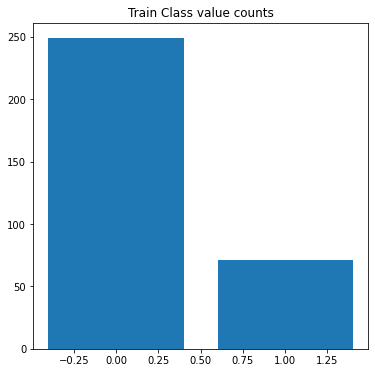

In [63]:
unique_values, counts = np.unique(train_classification_y, return_counts=True) 

print(f'Value counts : {unique_values, counts}')
print(f'Imbalance train ratio : {max(counts)/min(counts)}')
plt.figure(figsize=(6,6))
plt.bar(x=unique_values, height=counts)
plt.title('Train Class value counts')
plt.show()

Value counts : (array([0., 1.]), array([67, 13], dtype=int64))
Imbalance train ratio : 5.153846153846154


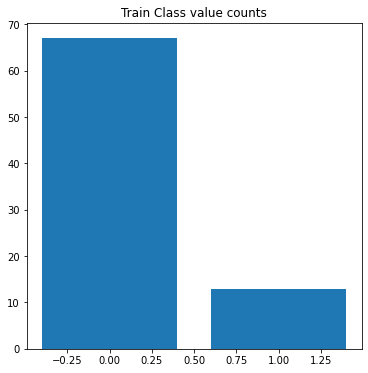

In [64]:
unique_values, counts = np.unique(test_classification_y, return_counts=True) 

print(f'Value counts : {unique_values, counts}')
print(f'Imbalance train ratio : {max(counts)/min(counts)}')
plt.figure(figsize=(6,6))
plt.bar(x=unique_values, height=counts)
plt.title('Train Class value counts')
plt.show()

In [ ]:
plt.figure(figsize=(6,6))
og_df['pcr'].value_counts().plot(kind='bar')
print(f'Value Counts : {og_df["pcr"].value_counts()}')
plt.show()

In [ ]:
scalerTrainX = StandardScaler()
scalerTrainY = StandardScaler()

trainX = scalerTrainX.fit_transform(xTrain_data)
trainY = train_classification_y.reshape(-1, 1).copy()

testX = scalerTrainX.transform(xTest_data)
testY = test_classification_y.reshape(-1, 1).copy()

In [128]:
classifier = RandomForestClassifier(random_state=0, verbose=1, class_weight='balanced')

In [129]:
classifier.fit(trainX, trainY.ravel())

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


RandomForestClassifier(class_weight='balanced', random_state=0, verbose=1)

In [130]:
predicted = classifier.predict(testX)
test_mse_error = balanced_accuracy_score(predicted, testY)
test_mae_error = mean_absolute_error(predicted, testY)
test_r2_error = r2_score(predicted, testY)

print(f'Balanced classification accuracy error: {test_mse_error}')
print(f'MAE error: {test_mae_error}')
print(f'R2 error: {test_r2_error}')

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
C:\Users\sudar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Balanced classification accuracy error: 0.8375
MAE error: 0.1625
R2 error: 0.0


In [131]:
confusion_matrix(testY, predicted)

array([[67,  0],
       [13,  0]], dtype=int64)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[[67  0]
 [13  0]]


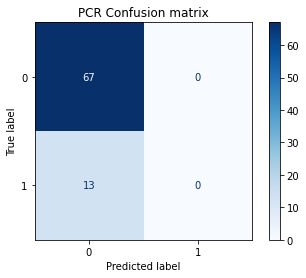

In [123]:
disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        testX,
        testY,
        display_labels=['0','1'],
        cmap=plt.cm.Blues,
        normalize=None)
    
disp.ax_.set_title("PCR Confusion matrix")
print(disp.confusion_matrix)

plt.show()

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


[[66  1]
 [12  1]]


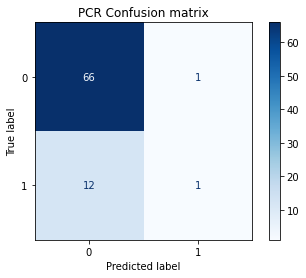

In [67]:
disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        testX,
        testY,
        display_labels=['0','1'],
        cmap=plt.cm.Blues,
        normalize=None)
    
disp.ax_.set_title("PCR Confusion matrix")
print(disp.confusion_matrix)

plt.show()